In [126]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx

In [127]:
#directories
dataset_name = 'mountain_dataset'
dataset_dir = f'datasets/{dataset_name}'
output_dir ="output"
g_matrix_filename = f"G_{dataset_name}.npy" #Name of the file where matrix G will be saved
gamma_filename = f"gamma_{dataset_name}.npy"
weight_matrix_filename = f"w_{dataset_name}.npy"

In [128]:
#This function loads images from a specific folder
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv.imread(os.path.join(folder,filename))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if img is not None:
            images.append(img)
    return images

In [129]:
#Load images from the folder
imgs = load_images_from_folder(dataset_dir)
n = len(imgs) #Number of images

#Load G matrix
G = np.load(os.path.join(output_dir,g_matrix_filename))
gamma = np.load(os.path.join(output_dir,gamma_filename))
weight_matrix = np.load(os.path.join(output_dir,weight_matrix_filename))

In [130]:
def buildAndPrintGraph(gamma, weight_matrix):
    G=nx.Graph()
    for i in range(0,n):
        G.add_node(i,image = imgs[i])
    for i in range(n): 
         for j in range(n): 
            if gamma[i,j] == 1:
                G.add_edge(i,j, weight=weight_matrix[i,j]) 
    pos=nx.circular_layout(G)
    fig=plt.figure(figsize=(15,15))
    ax=plt.subplot(111)
    ax.set_aspect('equal')
    nx.draw(G,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    trans=ax.transData.transform
    trans2=fig.transFigure.inverted().transform
    piesize=0.08 # this is the image size
    p2=piesize/0.9 #this is the image center
    for g in G:
        xx,yy=trans(pos[g]) # figure coordinates
        xa,ya=trans2((xx,yy)) # axes coordinates
        a = plt.axes([xa-p2,ya-p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[g]['image'])
        a.axis('off')
    ax.axis('off')
    plt.show()
    return G

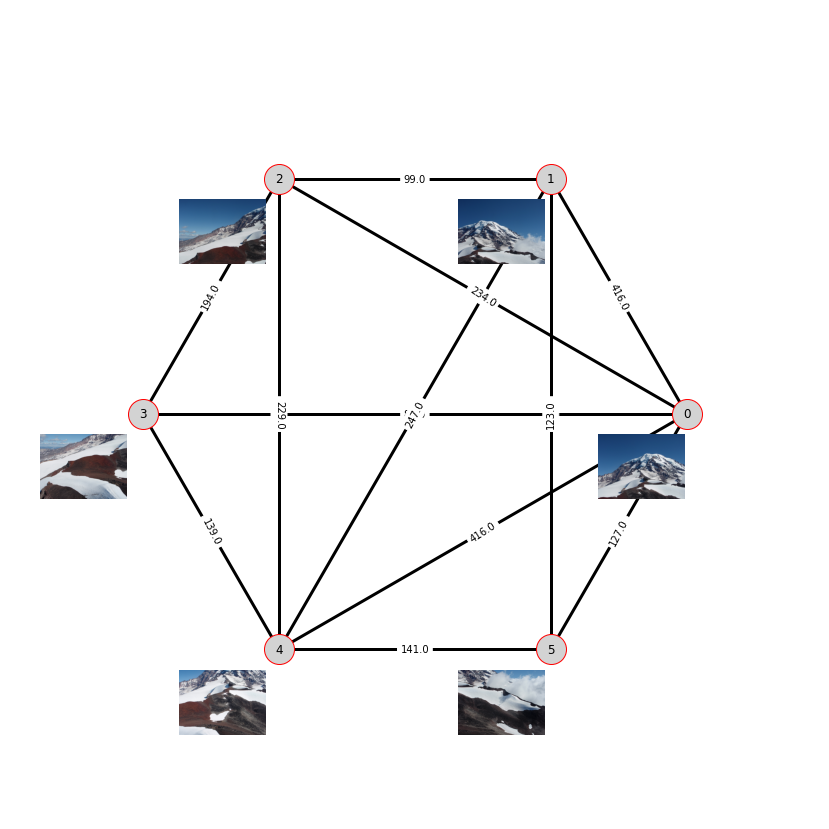

In [131]:
graph = buildAndPrintGraph(gamma = gamma, weight_matrix = weight_matrix)

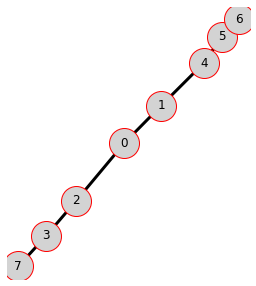

In [132]:
pos=nx.kamada_kawai_layout(spanning_tree)
fig=plt.figure(figsize=(5,5))
ax=plt.subplot(111)
ax.set_aspect('equal')
nx.draw(spanning_tree,pos,ax=ax, width = 3, node_size=900,with_labels = True, edgecolors='red', node_color='lightgray')
plt.show()


In [142]:
class Kmeans:
    def __init__(self, k=2, init_mode = "random"):  
        self.k=k
        self.init_mode = init_mode

    
    def fit(self, graph):
        if self.k > len(graph.nodes):
            raise Exception("K greater than the nodes!")
        self.graph = graph
        self.centroids = self.__init_centroids(mode = self.init_mode)
        self.old_centroids = self.centroids
        self.cluster = np.zeros(len(self.graph.nodes), dtype=int)
        self.distances = dict(nx.all_pairs_shortest_path_length(self.graph))
        
        while True:
            self.__assign_cluster()
            self.__update_centroids()
            if (self.old_centroids==self.centroids).all():
                return self.cluster
            self.old_centroids = self.centroids
        
            
        
    def __init_centroids(self, mode="random"):             
        if mode =="random":
            return np.random.choice(self.graph.nodes,self.k,replace=False)
            
        if mode =="leaves":
            spanning_tree = nx.maximum_spanning_tree(self.graph)
            leaves = []
            for node in self.graph.nodes:
                if len(spanning_tree[node])==1: #leaf
                    leaves.append(node)
            if len(leaves)>self.k:
                leaves=np.random.choice(leaves,self.k,replace=False)
            while len(leaves)<self.k:
                pseudo_leaf = np.random.choice(self.graph.nodes,1, replace=False)[0]
                if pseudo_leaf not in leaves:
                    leaves.append(pseudo_leaf)
            return np.array(leaves, dtype=int)
        
        return self.__init_centroids(mode="random")
    
            
    def __assign_cluster(self):
        for node in self.graph.nodes:
            if node in self.centroids:
                self.cluster[node] = np.where(self.centroids==node)[0]
            else:
                self.cluster[node] = 0
                min_distance, max_matches = self.__distance_from_centroid(node, self.centroids[0]) 
                for centroid in self.centroids[1:]:
                    distance, matches = self.__distance_from_centroid(node, centroid)
                    if distance<min_distance or (distance==min_distance and matches>max_matches):
                        self.cluster[node] = np.where(self.centroids==centroid)[0]
                        min_distance = distance
                        max_matches = matches
                                   
    
    def __distance_from_centroid(self, node, centroid):
        distance = self.distances[node][centroid]
        matches = 0
        if distance==1:
            matches = (self.graph.edges[node,centroid]["weight"] + self.graph.edges[centroid,node]["weight"])/2
        return distance, matches
                    
    def __update_centroids(self):
        for i in range(len(self.centroids)):
            elements_in_centroid = [j for j, x in enumerate(self.cluster) if x == i]
            min_distance = 0
            for node in elements_in_centroid:
                distance = np.mean([self.distances[node][d] for d in elements_in_centroid])
                if distance<min_distance:
                    min_distance = distance
                    self.centroids[i] = node
    


        

In [143]:
kmeans = Kmeans(k=2, init_mode="leaves")

In [144]:
cluster = kmeans.fit(graph)

In [145]:
cluster

array([1, 1, 1, 0, 1, 0])

In [137]:
cluster

array([3, 0, 3, 1, 3, 2])